# Install and Import Dependencies

In [1]:

# Install necessary libraries (if not already installed)
!pip install matplotlib scikit-image torch pillow

# Import libraries
import torch
import numpy as np
import torch.optim as optim
import torch.nn as nn
import math
from PIL import Image, ImageOps, ImageFilter, ImageEnhance
import random
import torch.nn.functional as F
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt


Defaulting to user installation because normal site-packages is not writeable


# Define the `StringArtGenerator` Class

In [3]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class StringArtGenerator:
    def __init__(self, nails=100, iterations=1000, weight=20):
        self.nails = nails
        self.iterations = iterations
        self.weight = weight
        self.seed = 0
        self.image = None
        self.data = None
        self.original_data = None
        self.nodes = []
        self.paths = []
        self.model = None
        self.optimizer = None
        self.loss_fn = nn.CrossEntropyLoss()

    def initialize_rl_model(self):
        image_size = self.data.size
        state_size = image_size + self.nails
        self.model = StringArtRLModel(
            state_size=state_size, action_size=self.nails).to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        print("RL model initialized on", device)

    def preprocess(self):
        self.image = ImageOps.grayscale(self.image)
        self.image = ImageOps.invert(self.image)
        self.image = self.image.filter(ImageFilter.EDGE_ENHANCE_MORE)
        self.image = ImageEnhance.Contrast(self.image).enhance(1)
        self.data = np.array(self.image, dtype=np.float64)
        self.original_data = self.data.copy()

    def set_nails(self, nails):
        self.nails = nails
        self._set_nodes()

    def _set_nodes(self):
        radius = self._get_radius()
        angle_step = 2 * math.pi / self.nails
        self.nodes = [
            (
                radius + radius * math.cos(i * angle_step),
                radius + radius * math.sin(i * angle_step),
            )
            for i in range(self.nails)
        ]

    def _get_radius(self):
        return min(self.data.shape) // 2

    def load_image(self, path):
        img = Image.open(path)
        self.image = img
        self.data = np.array(self.image, dtype=np.float64)

    def calculate_paths(self):
        self.paths = [
            [self.bresenham_path(self.nodes[i], self.nodes[j])
             for j in range(self.nails)]
            for i in range(self.nails)
        ]

    def bresenham_path(self, start, end):
        x1, y1 = map(int, start)
        x2, y2 = map(int, end)
        dx = abs(x2 - x1)
        dy = abs(y2 - y1)
        sx = 1 if x1 < x2 else -1
        sy = 1 if y1 < y2 else -1
        err = dx - dy
        path = []

        while True:
            if 0 <= y1 < self.data.shape[0] and 0 <= x1 < self.data.shape[1]:
                path.append((y1, x1))
            if x1 == x2 and y1 == y2:
                break
            e2 = err * 2
            if e2 > -dy:
                err -= dy
                x1 += sx
            if e2 < dx:
                err += dx
                y1 += sy

        return path

    def create_state(self, current_nail):
        flattened_image = self.data.flatten()
        nail_one_hot = np.zeros(self.nails, dtype=np.float32)
        nail_one_hot[current_nail] = 1.0
        state = np.concatenate((flattened_image, nail_one_hot))
        return torch.tensor(state, dtype=torch.float32).to(device)

    def calculate_reward(self, after_update):
        updated_data = self.data.copy()

        for y, x in after_update:
            if 0 <= y < updated_data.shape[0] and 0 <= x < updated_data.shape[1]:
                updated_data[y, x] -= self.weight
                if updated_data[y, x] < 0:
                    updated_data[y, x] = 0

        mse_current = np.mean((self.data - self.original_data) ** 2)
        mse_new = np.mean((updated_data - self.original_data) ** 2)

        return mse_current - mse_new

    def choose_next_nail(self, state, epsilon=0.1):
        if random.random() < epsilon:
            return random.randint(0, self.nails - 1)
        else:
            with torch.no_grad():
                q_values = self.model(state)
                return torch.argmax(q_values).item()

    def train_model(self, state, action, reward, next_state, done, gamma=0.99):
        q_values = self.model(state)

        with torch.no_grad():
            q_next_values = self.model(next_state)
            max_q_next = torch.max(q_next_values).item() if not done else 0.0
            target_q_value = reward + gamma * max_q_next

        target_q_values = q_values.clone().detach()
        target_q_values[action] = target_q_value

        loss = F.mse_loss(q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def generate(self, epsilon=0.1):
        current_nail = 0
        state = self.create_state(current_nail)
        pattern = []

        for _ in range(self.iterations):
            action = self.choose_next_nail(state, epsilon)
            next_nail = action
            self.paths.append((current_nail, next_nail))

            updated_image = self.bresenham_path(
                self.nodes[current_nail], self.nodes[next_nail])

            reward = self.calculate_reward(updated_image)

            for y, x in updated_image:
                if 0 <= y < self.data.shape[0] and 0 <= x < self.data.shape[1]:
                    self.data[y, x] -= self.weight
                    if self.data[y, x] < 0:
                        self.data[y, x] = 0

            next_state = self.create_state(next_nail)
            done = False

            self.train_model(state, action, reward, next_state, done)

            state = next_state
            pattern.append((current_nail, next_nail))
            current_nail = next_nail
        return pattern

    def visualize_pattern(self, pattern):
        plt.figure(figsize=(8, 8))
        plt.imshow(self.original_data, cmap="gray")
        plt.axis("off")

        for start, end in pattern:
            start_node = self.nodes[start]
            end_node = self.nodes[end]
            plt.plot(
                [start_node[0], end_node[0]], [start_node[1], end_node[1]], "r-", alpha=0.6
            )

        plt.show()


class StringArtRLModel(nn.Module):
    def __init__(self, state_size, action_size):
        super(StringArtRLModel, self).__init__()
        self.fc1 = nn.Linear(state_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, action_size)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

Using device: cuda


RL model initialized on cuda
Epoch 1
Epoch 1 Results: MSE = 86.84975625, SSIM = 0.9054623550051876
Epoch 2
Epoch 2 Results: MSE = 235.90784375, SSIM = 0.868911088197023
Epoch 3
Epoch 3 Results: MSE = 383.250575, SSIM = 0.8565590431849538
Model saved to string_art_model.pth.


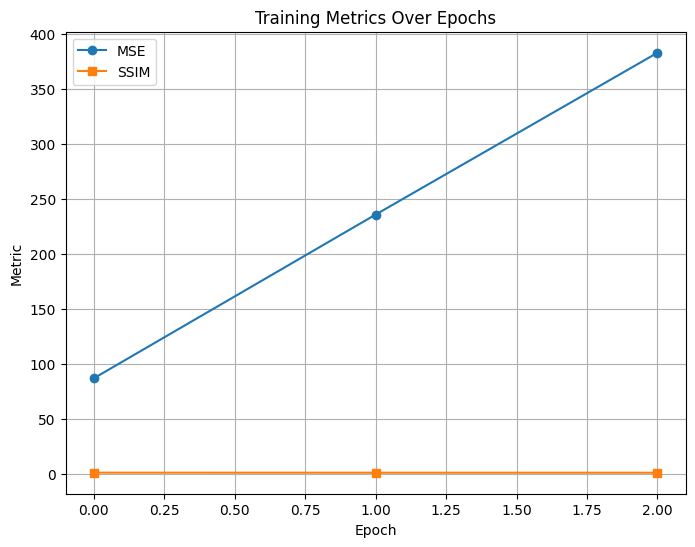

In [6]:
# Training model

# Configuration variables for training
NAILS = 100
ITERATIONS = 1000
WEIGHT = 20
TEST_IMAGE_PATH = "./demo/input/star.jpg"
EPOCHS = 3  # Number of epochs

# Set up the generator
generator = StringArtGenerator(
    nails=NAILS, iterations=ITERATIONS, weight=WEIGHT)
generator.load_image(TEST_IMAGE_PATH)
generator.preprocess()
generator.set_nails(NAILS)
generator.initialize_rl_model()

# Train for multiple epochs
mse_values = []
ssim_values = []

for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}")
    pattern = generator.generate()
    mse = np.mean((generator.data - generator.original_data) ** 2)
    ssim_score = ssim(
        generator.original_data,
        generator.data,
        data_range=generator.original_data.max() - generator.original_data.min(),
    )
    mse_values.append(mse)
    ssim_values.append(ssim_score)
    print(f"Epoch {epoch + 1} Results: MSE = {mse}, SSIM = {ssim_score}")

# Save the trained model
model_save_path = "string_art_model.pth"
torch.save(generator.model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}.")

# Plot training metrics
plt.figure(figsize=(8, 6))
plt.plot(mse_values, label="MSE", marker="o")
plt.plot(ssim_values, label="SSIM", marker="s")
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.title("Training Metrics Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

RL model initialized on cuda
Trained model loaded from string_art_model.pth.


/tmp/ipykernel_2548/3952431008.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_generator.model.load_state_dict(torch.load(model_save_path))


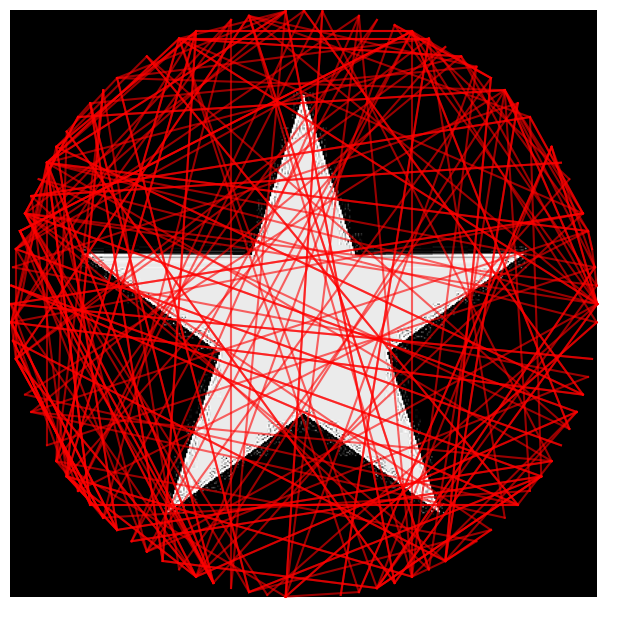

Test Evaluation Results: MSE = 57.20478125, SSIM = 0.9070063802379941


In [5]:
# Testing Model

TEST_IMAGE_PATH = "./demo/input/star.jpg"

# Set up the generator for testing
test_generator = StringArtGenerator(
    nails=NAILS, iterations=ITERATIONS, weight=WEIGHT)
test_generator.load_image(TEST_IMAGE_PATH)
test_generator.preprocess()
test_generator.set_nails(NAILS)
test_generator.initialize_rl_model()

# Load the trained model
test_generator.model.load_state_dict(torch.load(model_save_path))
test_generator.model.eval()
print(f"Trained model loaded from {model_save_path}.")

# Generate and visualize the pattern
test_pattern = test_generator.generate()
test_generator.visualize_pattern(test_pattern)

# Evaluate the pattern
test_mse = np.mean((test_generator.data - test_generator.original_data) ** 2)
test_ssim = ssim(
    test_generator.original_data,
    test_generator.data,
    data_range=test_generator.original_data.max() - test_generator.original_data.min(),
)
print(f"Test Evaluation Results: MSE = {test_mse}, SSIM = {test_ssim}")